In [71]:
import pandas as pd

brent = pd.read_csv("datathon data/crude_oil/BRENT.csv")
makeup = pd.read_csv("datathon data/monthly_gasoline_makeup_percentages.csv")
makeup = makeup[makeup['Type'] == 'Regular']
gas_prices = pd.read_csv("datathon data/gas_prices/regular_formulated_gas_prices.csv")

brent = brent.rename({"Price":"Brent_Price"}, axis=1)
# Ensure dates are in datetime format
makeup['Date'] = pd.to_datetime(makeup['Date'])
gas_prices['Date'] = pd.to_datetime(gas_prices['Date'])
brent['Date'] = pd.to_datetime(brent['Date'])

# Extract Year and Month in both DataFrames
makeup['Year'] = makeup['Date'].dt.year
makeup['Month'] = makeup['Date'].dt.month
gas_prices['Year'] = gas_prices['Date'].dt.year
gas_prices['Month'] = gas_prices['Date'].dt.month
brent['Year'] = brent['Date'].dt.year
brent['Month'] = brent['Date'].dt.month

## Interpolate Monthly Makeup to Weekly
- same values for this month
- linearly interpolate

In [56]:
makeup.columns

Index(['Date_String', 'Date', 'Retail_Price', 'Refining',
       'Distribution_and_Marketing', 'Taxes', 'Crude_Oil', 'Type', 'Year',
       'Month'],
      dtype='object')

In [72]:
# Identify the first weekly entry of each month
first_week = gas_prices.groupby(['Year', 'Month'])['Date'].min().reset_index()
gas_prices_same = pd.merge(gas_prices, makeup, on=['Year', 'Month'], how='left').drop(columns=['Date_y', 'Date_String']).rename({"Date_x":"Date"}, axis=1)

# Merge with monthly makeup data on Year and Month
merged = pd.merge(first_week, makeup, on=['Year', 'Month'], how='left')

# Now map these monthly values back to the gas_prices DataFrame
gas_prices_combined = pd.merge(gas_prices, merged[['Date_x', 'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil']], 
                      left_on='Date', right_on='Date_x', how='left')

# Drop the merge helper column
gas_prices_combined.drop(columns='Date_x', inplace=True)

gas_prices_linear = gas_prices_combined

# Interpolate the missing values linearly
for col in ['Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil']:
    gas_prices_linear[col] = gas_prices_linear[col].interpolate(method='linear', limit_direction='both')


## Aggregate Brent to Weekly (average)

In [70]:
brent

,Date,Brent Price,Commodity,Commodity_Simple,Unit,Year,Month
0,2024-01-22,81.70,Brent Crude Oil,BRENT,Dollars per Barrel,2024,1
1,2024-01-19,80.71,Brent Crude Oil,BRENT,Dollars per Barrel,2024,1
2,2024-01-18,81.04,Brent Crude Oil,BRENT,Dollars per Barrel,2024,1
3,2024-01-17,78.88,Brent Crude Oil,BRENT,Dollars per Barrel,2024,1
4,2024-01-16,80.15,Brent Crude Oil,BRENT,Dollars per Barrel,2024,1
...,...,...,...,...,...,...,...
9564,1987-05-26,18.63,Brent Crude Oil,BRENT,Dollars per Barrel,1987,5
9565,1987-05-25,18.60,Brent Crude Oil,BRENT,Dollars per Barrel,1987,5
9566,1987-05-22,18.55,Brent Crude Oil,BRENT,Dollars per Barrel,1987,5
9567,1987-05-21,18.45,Brent Crude Oil,BRENT,Dollars per Barrel,1987,5


In [73]:
brent_weekly = brent.resample('W-MON', on='Date')['Brent_Price'].mean().reset_index()
gas_brent_linear = pd.merge(gas_prices_linear, brent_weekly, on='Date', how ='inner')
gas_brent_same = pd.merge(gas_prices_same, brent_weekly, on='Date', how ='inner')

In [75]:
gas_brent_linear.to_csv("datathon data/gas_prices/regular_formulated_gas_prices_rf_linear.csv")
gas_brent_same.to_csv("datathon data/gas_prices/regular_formulated_gas_prices_rf_same.csv")

In [76]:
gas_brent_linear.columns

Index(['Date', 'Year', 'Type', 'Type_Clean', 'Unit', 'Geography', 'Price',
       'Month', 'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil',
       'Brent_Price'],
      dtype='object')

### Feature Engineering

In [91]:
import numpy as np
# Get the pct and logreturn
for col in ['Price', 'Brent_Price', 'Refining', 'Taxes', 'Distribution_and_Marketing', 'Crude_Oil']:
    gas_brent_linear[f'{col}_logreturn'] = np.log(gas_brent_linear[col] / gas_brent_linear[col].shift(1))
    gas_brent_linear[f'{col}_pct'] = gas_brent_linear[col].pct_change()
    gas_brent_same[f'{col}_logreturn'] = np.log(gas_brent_same[col] / gas_brent_same[col].shift(1))
    gas_brent_same[f'{col}_pct'] = gas_brent_same[col].pct_change()

/Users/yangzejia/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/yangzejia/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Train XGBoost and Random Forest

In [96]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

['Brent_Price_logreturn', 'Refining_logreturn', 'Taxes_logreturn', 'Distribution_and_Marketing_logreturn', 'Crude_Oil_logreturn']
MSE: 0.00038749102327579455
Feature Importantce                                 feature  importance
2                       Taxes_logreturn    0.462318
0                 Brent_Price_logreturn    0.195524
3  Distribution_and_Marketing_logreturn    0.183352
4                   Crude_Oil_logreturn    0.083464
1                    Refining_logreturn    0.075342


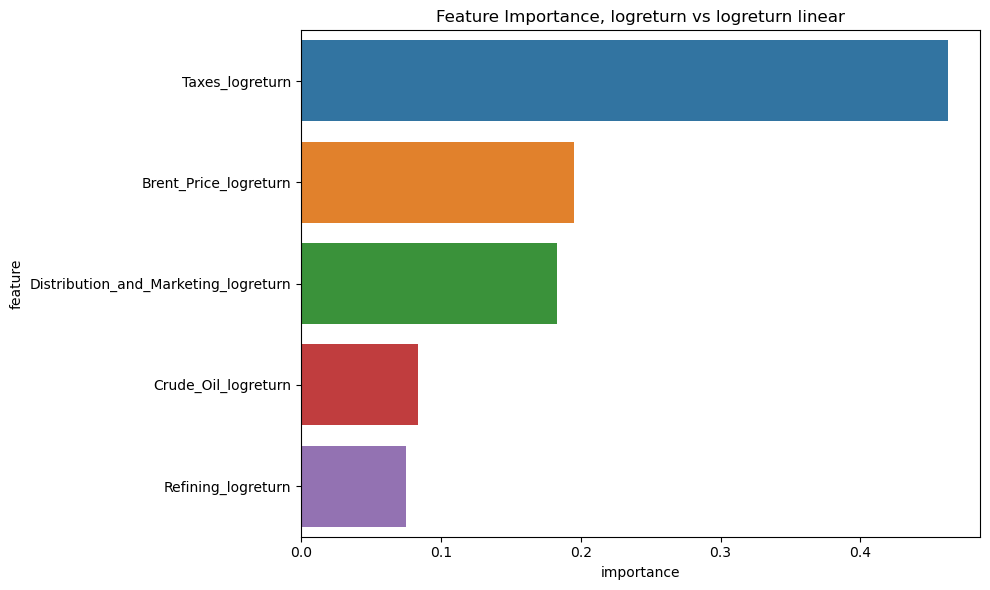

In [99]:
# Drop NA rows due to lag
gas_brent_linear = gas_brent_linear.dropna()

# Features and target, to fit log return 
feature_cols = [col for col in gas_brent_linear.columns if '_logreturn' in col and col != 'Price_logreturn']
print(feature_cols)
X = gas_brent_linear[feature_cols]
y = gas_brent_linear['Price_logreturn']  # or 'Price' or 'Price_pct'

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model
model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

importance = model.feature_importances_
feat_importance = pd.DataFrame({'feature': X.columns, 'importance': importance})
feat_importance = feat_importance.sort_values('importance', ascending=False)

print("Feature Importantce", feat_importance)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_importance)
plt.title("Feature Importance, logreturn vs logreturn linear")
plt.tight_layout()
plt.show()


In [113]:
lag = 1
gas_brent_linear[f'Price_lag_{lag}'] = gas_brent_linear['Price'].shift(lag)

# Features and target, to fit log return 
feature_cols = [
    f'Price_lag_{lag}',
        'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil',
       'Brent_Price', 'Brent_Price_logreturn',
        'Refining_logreturn',
       'Taxes_logreturn',  'Distribution_and_Marketing_logreturn',
        'Crude_Oil_logreturn',
       ]
print(feature_cols)
X = gas_brent_linear[feature_cols]
y = gas_brent_linear['Price']  # or 'Price' or 'Price_pct'

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model
model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

importance = model.feature_importances_
feat_importance = pd.DataFrame({'feature': X.columns, 'importance': importance})
feat_importance = feat_importance.sort_values('importance', ascending=False)

print("Feature Importantce", feat_importance)

['Price_lag_1', 'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil', 'Brent_Price', 'Brent_Price_logreturn', 'Refining_logreturn', 'Taxes_logreturn', 'Distribution_and_Marketing_logreturn', 'Crude_Oil_logreturn']
MSE: 0.05931326878982444
Feature Importantce                                  feature  importance
3                                  Taxes    0.571032
0                            Price_lag_1    0.415242
5                            Brent_Price    0.011093
9   Distribution_and_Marketing_logreturn    0.000533
1                               Refining    0.000364
4                              Crude_Oil    0.000355
8                        Taxes_logreturn    0.000350
10                   Crude_Oil_logreturn    0.000343
6                  Brent_Price_logreturn    0.000272
7                     Refining_logreturn    0.000249
2             Distribution_and_Marketing    0.000167


In [114]:
feature_cols = [f'Price_lag_{lag}',
        'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil',
       'Brent_Price', 'Brent_Price_logreturn',
        'Refining_logreturn',
       'Taxes_logreturn',  'Distribution_and_Marketing_logreturn',
        'Crude_Oil_logreturn',
       ]
print(feature_cols)
X = gas_brent_linear[feature_cols]
y = gas_brent_linear['Price_logreturn']  # or 'Price' or 'Price_pct'

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model
model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

importance = model.feature_importances_
feat_importance = pd.DataFrame({'feature': X.columns, 'importance': importance})
feat_importance = feat_importance.sort_values('importance', ascending=False)

print("Feature Importantce", feat_importance)


['Price_lag_1', 'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil', 'Brent_Price', 'Brent_Price_logreturn', 'Refining_logreturn', 'Taxes_logreturn', 'Distribution_and_Marketing_logreturn', 'Crude_Oil_logreturn']
MSE: 0.000381098053318308
Feature Importantce                                  feature  importance
8                        Taxes_logreturn    0.436199
6                  Brent_Price_logreturn    0.137690
9   Distribution_and_Marketing_logreturn    0.131914
2             Distribution_and_Marketing    0.046224
3                                  Taxes    0.043145
7                     Refining_logreturn    0.041830
10                   Crude_Oil_logreturn    0.038725
1                               Refining    0.034164
4                              Crude_Oil    0.033444
5                            Brent_Price    0.031940
0                            Price_lag_1    0.024725
